In [26]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("/home/ubuntu/graphseq-inference/")
from graphseq_inference.data_utils import *
from graphseq_inference.models import *
from graphseq_inference.train_utils import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def get_mid_trees(ts):

    for i, tree in enumerate(ts.trees()):
        if tree.interval.left >= (ts.sequence_length/2):
            break

    first_tree = i-249
    last_tree = i + 250
    
    trees = []
    for j, tree in enumerate(ts.aslist()):
        if j >= first_tree and j <= last_tree:
            trees.append(tree)
            
    return trees

In [28]:
directory = "./validation_classification_dataset/"

files = os.listdir(directory)
files = [directory +  file for file in files]

In [29]:
len(files)

1814

In [5]:
def preorder_dist(tree):
    result = []
    for root in tree.roots:
        stack = [(root, (-1, root) , (tree.get_time(tree.root), 0))]
        while len(stack) > 0:
            u, pc, time = stack.pop()
            result.append((u, pc, time))
            for v in tree.children(u):
                stack.append((v, (u,v) , (tree.get_time(u),tree.get_time(v))))
    return result

def restructure_result(result):


    is_modified = True
    while True:

        if not is_modified: break
        is_modified = False

        for i, (idx_node, (parent, node), (time_parent, time_node)) in enumerate(result):
            branch_length = time_parent - time_node
            
            
            
            #if branch_length < (time_parent*threshold) and branch_length != 0 and (parent != node):
            

            threshold = 20
            
            if time_parent < 200:
                threshold = 20
            
            if time_parent < 20:
                threshold = 2
                
            if time_parent < 10:
                threshold = 1
                
            if time_parent < 5:
                threshold = 0.5
                
            
            if branch_length < threshold and branch_length != 0 and (parent != node):
    
                
                new_time = (time_parent+time_node)/2
                result[i] = (-1, (parent, parent), (time_parent, time_parent))
                for j, (_, (p, n), (tp, tn)) in enumerate(result):
                    if node == n:
                        result[j] = (-1, (p, parent), (tp, time_parent))#
                    if node == p:
                        result[j] = (-1, (parent, n), (time_parent, tn))

                is_modified = True
                break

    new_result = []
    for a, (b,c), (d, e) in result:
        if b != c:
            new_result.append((a, (b,c), (d,e)))
    return new_result

def multiple_mergerized_to_data_object(result):

    G = nx.Graph()
    for _, edge, times in result[:-1]:
        a, b = edge
        ta, tb = times
        branch = ta - tb
        G.add_weighted_edges_from([(a, b, branch)])
        
    data = from_networkx(G)
    rename_data_attribute(data, "weight", "edge_weight") 

    return data







def tree_to_data_objects(tree, num_embedding=60):
    max_num_nodes = 2 * 10 - 1 

    data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
    rename_data_attribute(data, "branch_length", "edge_weight") 
    num_nodes = data.num_nodes
    data.x = torch.eye(max_num_nodes,num_embedding)
    data.x[num_nodes:] = torch.zeros(num_embedding)
    data.num_nodes = max_num_nodes
    return data


def tree_to_restructured_data_objects(tree, num_embedding=60):
    result = preorder_dist(tree)
    result.reverse()
    result = restructure_result(result)    
    data = multiple_mergerized_to_data_object(result)
    
    max_num_nodes = 2 * 10 - 1 
    num_nodes = data.num_nodes
    data.x = torch.eye(max_num_nodes,num_embedding)
    data.x[num_nodes:] = torch.zeros(num_embedding)
    data.num_nodes = max_num_nodes
    
    return data

In [6]:

def get_y_label_from_y_dict(y_dict):
    reproduction_model, parameter = y_dict["model"]

    if reproduction_model == "beta":
        if parameter < 1.25:
            return torch.Tensor([7]).long()
        if parameter < 1.5:
            return torch.Tensor([6]).long()
        if parameter < 1.75:
            return torch.Tensor([5]).long()
        if parameter < 2:
            return torch.Tensor([4]).long()

    else:
        label = y_dict["model"][0] + "_selection_" + y_dict["selection_type"]
        y = torch.Tensor([label_lookup[label]]).long()
        return y

def convert_for_classification(file: tskit.trees.TreeSequence,
                                num_embedding:int = 60, restructure=False,
                           ):
    
    ts, y_dict = torch.load(file)
    
    y = get_y_label_from_y_dict(y_dict)
    
    #label = y_dict["model"][0] + "_selection_" + y_dict["selection_type"]
    #y = torch.Tensor([label_lookup[label]]).long()
    trees = get_mid_trees(ts)
    
        
    if restructure:
        data_objects = [tree_to_restructured_data_objects(tree) for tree in trees]
    else:
        data_objects = [tree_to_data_objects(tree) for tree in trees]
        
    
    for data in data_objects:
        data.y = y
    
    
    #for i, tree in enumerate(trees):            
    #    data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
    #    rename_data_attribute(data, "branch_length", "edge_weight") 
    #    num_nodes = data.num_nodes
    #    data.x = torch.eye(max_num_nodes,num_embedding)
    #    data.x[num_nodes:] = torch.zeros(num_embedding)
    #    data.y = y
    #    data.num_nodes = max_num_nodes
    #    data_objects.append(data)
        
    return data_objects

In [7]:
class ClassificationModel(nn.Module):
    
    def __init__(self, DemographyNet, num_classes, time_window=60):
        super().__init__()
        self.l1 = nn.Linear(time_window, time_window//2)
        self.l2 = nn.Linear(time_window//2, num_classes)
        self.DemographyNet = DemographyNet
    
    def forward(self, batch):
        x = self.DemographyNet(batch)
        return self.l2(F.relu(self.l1(x)))
    
    


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60)
model = ClassificationModel(demography_net, num_classes=8).to(device)

model_path = "./classifcation_model/mmc_diffpool_model_classification_norestruct_0_99999.pth"
model.load_state_dict(torch.load(model_path))




<All keys matched successfully>

In [16]:
0

0

In [10]:

label_lookup = {
    "kingman_selection_none" : 0,
    "kingman_selection_weak" : 1,
    "kingman_selection_medium" : 2,
    "kingman_selection_strong" : 3,
    
    "beta_selection_none" : 4,
    "beta_selection_weak" : 5,
    "beta_selection_medium" : 6,
    "beta_selection_strong" : 7,    
}



In [11]:
y_trues = []
y_hats = []

with torch.no_grad():

    for i, file in enumerate(tqdm(files)):
        
        if i < 1000:


            data_objects = convert_for_classification(file, restructure=False)

            dl = DataLoader(data_objects, batch_size=len(data_objects))

            for batch in dl:
                batch = batch.to(device)
                y_hat = model(batch)
                y_hat = y_hat.mean(0)
                y_true = batch.y[0]

            y_trues.append(y_true.cpu().item())
            y_hats.append(torch.argmax(y_hat).cpu().item())

100%|███████████████████████████████████████| 1814/1814 [05:51<00:00,  5.16it/s]


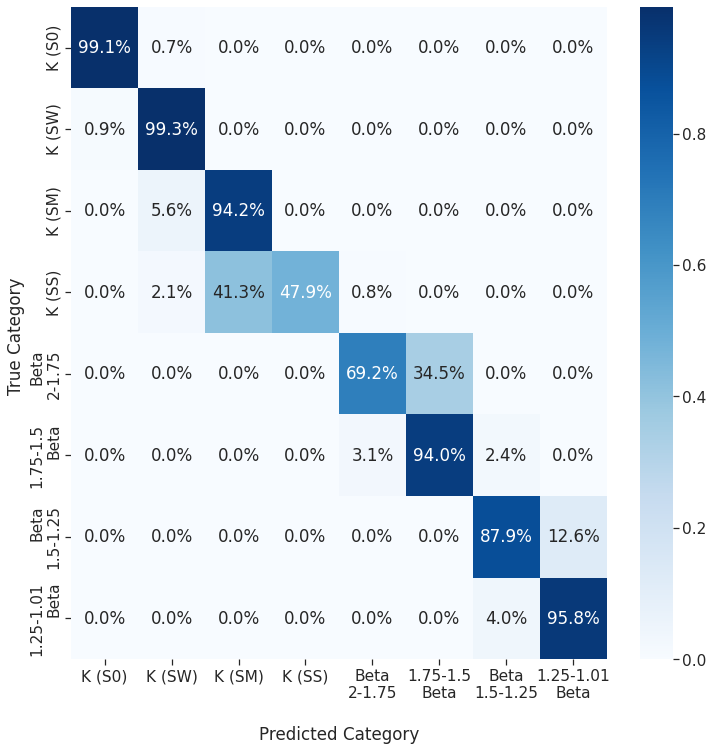

In [25]:
sns.set(font_scale=1.4)
sns.set_style("ticks")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_trues, y_hats)

label_renaming = {
    "kingman_selection_none" : "K (S0)",
    "kingman_selection_weak" : "K (SW)",
    "kingman_selection_medium" : "K (SM)",
    "kingman_selection_strong" : "K (SS)",
    
    "beta_selection_none" : "Beta\n2-1.75",
    "beta_selection_weak" : "1.75-1.5\nBeta",
    "beta_selection_medium" : "Beta\n1.5-1.25",
    "beta_selection_strong" : "1.25-1.01\nBeta",    
}

labels = list(label_renaming.keys())

renamed_labels = []
for label in labels:
    renamed_labels.append(label_renaming[label])

fig, ax = plt.subplots(1,1, figsize=(12, 12), sharex=True, sharey=False)

    
#ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix,1), annot=True, fmt='.1%', cmap='Blues')

#ax.set_title('Confusion matrix with training\non non-restructed tree sequences\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('True Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(ticklabels = renamed_labels)
ax.yaxis.set_ticklabels(ticklabels = renamed_labels)


plt.savefig("./figures/figure_5.png", dpi=400)

In [240]:
embedding_model = deepcopy(model)

In [241]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

In [242]:
embedding_model.l1 = Identity()
embedding_model.l2 = Identity()

torch.Size([500])

In [243]:
y_trues = []
y_hats = []

with torch.no_grad():
    for i, file in enumerate(tqdm(files)):
        
        if i < 1000:

            
            data_objects = convert_for_classification(file, restructure=False)

            dl = DataLoader(data_objects, batch_size=len(data_objects))

            for batch in dl:
                batch = batch.to(device)
                y_hat = embedding_model(batch)
                y_hat = y_hat.mean(0)
                y_true = batch.y[0]

            y_trues.append(y_true.cpu().item())
            y_hats.append(y_hat.cpu().detach().numpy())

100%|███████████████████████████████████████| 1000/1000 [06:11<00:00,  2.69it/s]


In [244]:
parameters = []
with torch.no_grad():
    for i, file in enumerate(tqdm(files)):
        
        ts, y_dict = torch.load(file)
        coalescent, parameter = y_dict["model"]
        parameters.append(parameter)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 607.90it/s]


In [266]:
import umap


m = np.stack(y_hats)
embedding = umap.UMAP(random_state=42).fit_transform(m)

In [267]:
embedding = pd.DataFrame([embedding[:, 0], embedding[:, 1]]).T
embedding.columns = ["e0", "e1"]

embedding["kingman"] = np.array(y_trues) < 4
embedding["beta"] = np.array(y_trues) >= 4


knosec = [True if i in [0] else False for i in y_trues]
embedding["no selection (kingman)"] = knosec
kweak = [True if i in [1] else False for i in y_trues]
embedding["weak selection (kingman)"] = kweak
kmedium = [True if i in [2] else False for i in y_trues]
embedding["medium selection (kingman)"] = kmedium
kstrong = [True if i in [3] else False for i in y_trues]
embedding["strong selection (kingman)"] = kstrong


bnosec = [True if i in [4] else False for i in y_trues]
embedding["no selection (beta)"] = bnosec
bweak = [True if i in [5] else False for i in y_trues]
embedding["weak selection (beta)"] = bweak
bmedium = [True if i in [6] else False for i in y_trues]
embedding["medium selection (beta)"] = bmedium
bstrong = [True if i in [7] else False for i in y_trues]
embedding["strong selection (beta)"] = bstrong

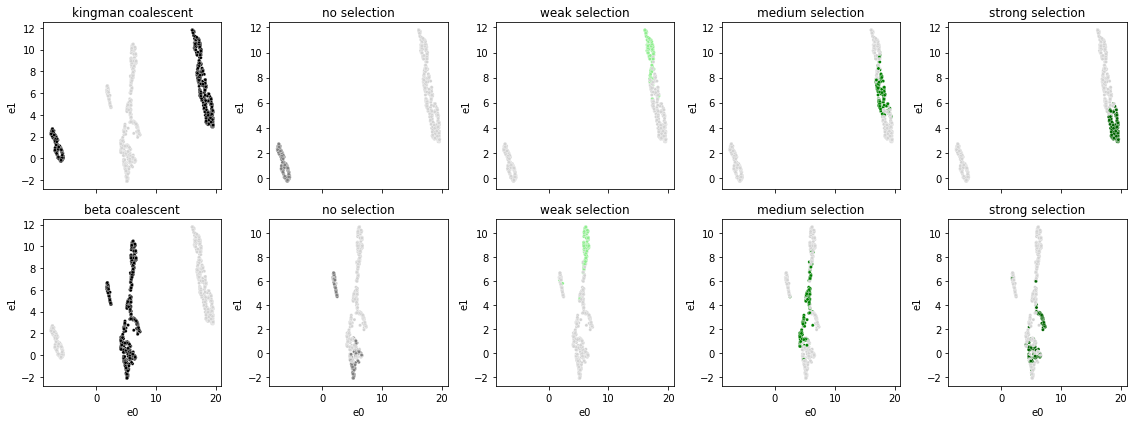

In [276]:
fig, axs = plt.subplots(2,5, figsize=(16, 6), sharex=True, sharey=False)
sns.scatterplot(data=embedding, x="e0", y="e1", hue="kingman", s=10, palette=["lightgrey", "black"], ax=axs[0][0], legend=False).set(title="kingman coalescent")
sns.scatterplot(data=embedding, x="e0", y="e1", hue="beta", s=10, palette=["lightgrey", "black"], ax=axs[1][0], legend=False).set(title="beta coalescent")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="no selection (kingman)", s=10, palette=["lightgrey", "grey"], ax=axs[0][1], legend=False).set(title="no selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="no selection (beta)", s=10, palette=["lightgrey", "grey"], ax=axs[1][1], legend=False).set(title="no selection")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="weak selection (kingman)", s=10, palette=["lightgrey", "lightgreen"], ax=axs[0][2], legend=False).set(title="weak selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="weak selection (beta)", s=10, palette=["lightgrey", "lightgreen"], ax=axs[1][2], legend=False).set(title="weak selection")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="medium selection (kingman)", s=10, palette=["lightgrey", "green"], ax=axs[0][3], legend=False).set(title="medium selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="medium selection (beta)", s=10, palette=["lightgrey", "green"], ax=axs[1][3], legend=False).set(title="medium selection")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="strong selection (kingman)", s=10, palette=["lightgrey", "darkgreen"], ax=axs[0][4], legend=False).set(title="strong selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="strong selection (beta)", s=10, palette=["lightgrey", "darkgreen"], ax=axs[1][4], legend=False).set(title="strong selection")

plt.tight_layout()
plt.savefig("./figures/selection_umap_nostruct_2epochs.png", dpi=400)

In [269]:
parameters = [2 if parameter == None else parameter for parameter in parameters]
embedding["strength"] = parameters

In [270]:
embedding["low_alpha"] = embedding["strength"] < 1.3
embedding["medium_alpha"]  = np.logical_and(embedding["strength"] < 1.7, embedding["strength"] >= 1.3)
embedding["high_alpha"]  = np.logical_and(embedding["strength"] >= 1.7, embedding["strength"] < 2)


In [288]:
#fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharex=True, sharey=False)

#sns.scatterplot(data=embedding, x="e0", y="e1",hue="kingman", palette=["lightgrey", "black"],s=10,legend=False, ax=axs[0]).set(title="kingman coalescent")
#sns.scatterplot(data=embedding, x="e0", y="e1",hue="beta", palette=["lightgrey", "black"],s=10,legend=False, ax=axs[1]).set(title="beta coalescent")
#sns.scatterplot(data=embedding, x="e0", y="e1",hue="low_alpha", s=10,legend=False, palette=["lightgrey", "#99CCFF"], ax=axs[4]).set(title=" alpha < 1.3")
#sns.scatterplot(data=embedding, x="e0", y="e1",hue="medium_alpha", s=10,legend=False, palette=["lightgrey", "blue"], ax=axs[3]).set(title=" alpha >= 1.3 and < 1.7")
#sns.scatterplot(data=embedding, x="e0", y="e1",hue="high_alpha", s=10,legend=False, palette=["lightgrey", "darkblue"], ax=axs[2]).set(title=" alpha >= 1.7 and < 2.0")

#plt.tight_layout()
#plt.savefig("./figures/alpha_umap_nostruct_2epochs.png", dpi=400)

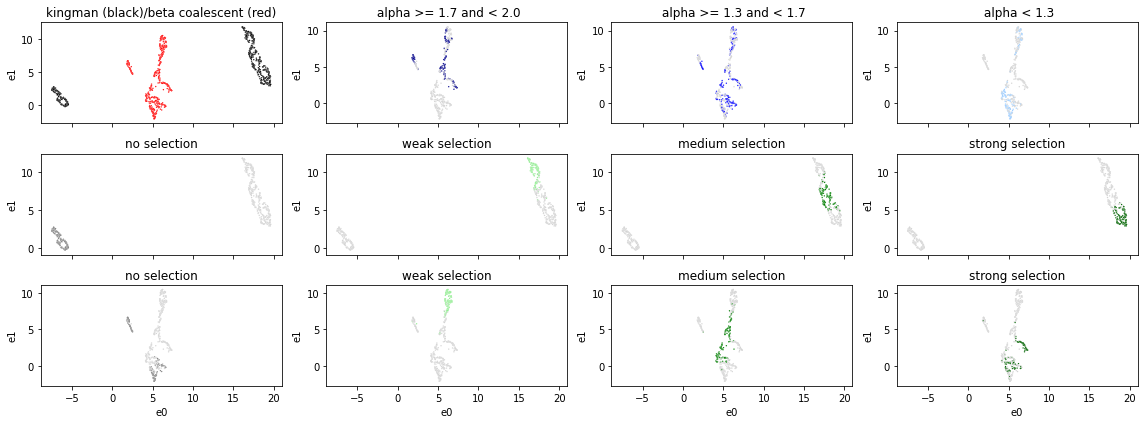

In [287]:
fig, axs = plt.subplots(3,4, figsize=(16, 6), sharex=True, sharey=False)

s = 2

sns.scatterplot(data=embedding, x="e0", y="e1", hue="kingman", s=s, palette=["red", "black"], ax=axs[0][0], legend=False).set(title="kingman (black)/beta coalescent (red)")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1",hue="low_alpha", s=s,legend=False, palette=["lightgrey", "#99CCFF"], ax=axs[0][3]).set(title=" alpha < 1.3")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1",hue="medium_alpha", s=s,legend=False, palette=["lightgrey", "blue"], ax=axs[0][2]).set(title=" alpha >= 1.3 and < 1.7")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1",hue="high_alpha", s=s,legend=False, palette=["lightgrey", "darkblue"], ax=axs[0][1]).set(title=" alpha >= 1.7 and < 2.0")


sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="no selection (kingman)", s=s, palette=["lightgrey", "grey"], ax=axs[1][0], legend=False).set(title="no selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="no selection (beta)", s=s, palette=["lightgrey", "grey"], ax=axs[2][0], legend=False).set(title="no selection")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="weak selection (kingman)", s=s, palette=["lightgrey", "lightgreen"], ax=axs[1][1], legend=False).set(title="weak selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="weak selection (beta)", s=s, palette=["lightgrey", "lightgreen"], ax=axs[2][1], legend=False).set(title="weak selection")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="medium selection (kingman)", s=s, palette=["lightgrey", "green"], ax=axs[1][2], legend=False).set(title="medium selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="medium selection (beta)", s=s, palette=["lightgrey", "green"], ax=axs[2][2], legend=False).set(title="medium selection")

sns.scatterplot(data=embedding[embedding["kingman"]], x="e0", y="e1", hue="strong selection (kingman)", s=s, palette=["lightgrey", "darkgreen"], ax=axs[1][3], legend=False).set(title="strong selection")
sns.scatterplot(data=embedding[embedding["beta"]], x="e0", y="e1", hue="strong selection (beta)", s=s, palette=["lightgrey", "darkgreen"], ax=axs[2][3], legend=False).set(title="strong selection")

plt.tight_layout()
plt.savefig("./figures/selection_alpha_umap_nostruct_2epochs.png", dpi=400)